### Let's Build the following Model:
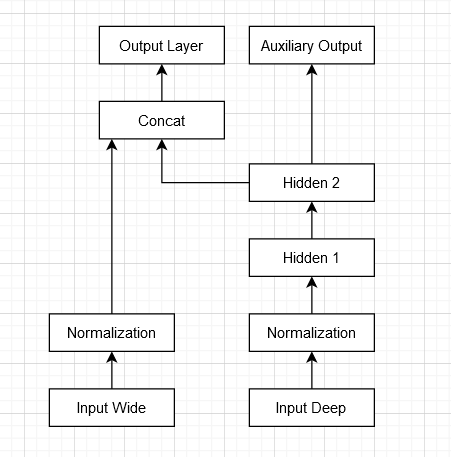

In [1]:
import tensorflow as tf

class WideAndDeepModel(tf.keras.Model):
    def __init__(self, units=30, activation='relu', **kwargs):
        super().__init__(**kwargs) # needed to support nameing the model
        self.norm_layer_wide = tf.keras.layers.Normalization()
        self.norm_layer_deep = tf.keras.layers.Normalization()
        self.hidden1 = tf.keras.layers.Dense(units, activation=activation)
        self.hidden2 = tf.keras.layers.Dense(units, activation=activation)
        self.main_output = tf.keras.layers.Dense(1)
        self.aux_output = tf.keras.layers.Dense(1)
        
    def call(self, inputs):
        input_wide, input_deep = inputs
        norm_wide = self.norm_layer_wide(input_wide)
        norm_deep = self.norm_layer_deep(input_deep)
        hidden1 = self.hidden1(norm_deep)
        hidden2 = self.hidden2(hidden1)
        concat = tf.keras.layers.concatenate([norm_wide, hidden2])
        output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return output, aux_output
    
model = WideAndDeepModel(30, activation="relu", name="my_cool_model")

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

housing = pd.read_csv('data/housing.csv')
housing.dropna(inplace=True)
housing.drop(columns=['ocean_proximity'], inplace=True)

X = housing.drop(columns=['median_house_value'])
y = housing['median_house_value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

In [3]:
X_train_wide, X_train_deep = X_train.iloc[:, :5], X_train.iloc[:, 2:]
X_test_wide, X_test_deep = X_test.iloc[:, :5], X_test.iloc[:, 2:]
X_new_wide, X_new_deep = X_test_wide.iloc[:3], X_test_deep.iloc[:3]

In [4]:
model.compile(
    loss = ("mse","mse"),
    loss_weights= (0.9, 0.1),
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
history = model.fit((X_train_wide, X_train_deep), (y_train,y_train), epochs=10, validation_split=0.1)

Epoch 1/10
489/489 [==============================] - 4s 3ms/step - loss: 38876635136.0000 - output_1_loss: 38555402240.0000 - output_2_loss: 41768218624.0000 - output_1_root_mean_squared_error: 196355.2969 - output_2_root_mean_squared_error: 204372.7500 - val_loss: 27994130432.0000 - val_output_1_loss: 27944263680.0000 - val_output_2_loss: 28442888192.0000 - val_output_1_root_mean_squared_error: 167165.3750 - val_output_2_root_mean_squared_error: 168650.1875
Epoch 2/10
489/489 [==============================] - 1s 2ms/step - loss: 27438211072.0000 - output_1_loss: 27424462848.0000 - output_2_loss: 27561834496.0000 - output_1_root_mean_squared_error: 165603.3281 - output_2_root_mean_squared_error: 166017.5781 - val_loss: 27658633216.0000 - val_output_1_loss: 27657033728.0000 - val_output_2_loss: 27673063424.0000 - val_output_1_root_mean_squared_error: 166304.0469 - val_output_2_root_mean_squared_error: 166352.2344
Epoch 3/10
489/489 [==============================] - 1s 2ms/step - loss

In [5]:
model.evaluate((X_test_wide,X_test_deep), (y_test,y_test))

96/96 [==============================] - 0s 2ms/step - loss: 22450470912.0000 - output_1_loss: 22442113024.0000 - output_2_loss: 22525741056.0000 - output_1_root_mean_squared_error: 149806.9219 - output_2_root_mean_squared_error: 150085.7812


[22450470912.0, 22442113024.0, 22525741056.0, 149806.921875, 150085.78125]

This API provides some extra flexibility, specially for the researchers, but still it has cons as well. In the method the model architecture is hidden within the call method, it is not possible to clone this model using tf.keras.models.clone_model() and when using model.summery() method, it will only shows the layers without any information. So, it is easier to make mistakes. Finally, unless we need extra flexbility we should stuck on the sequential or the functional API.

### Saving and Restoring a Model

In [6]:
model.save("my_keras_model", save_format="tf")

INFO:tensorflow:Assets written to: my_keras_model\assets


INFO:tensorflow:Assets written to: my_keras_model\assets


save_format="tf" means create a directory containing several files and sub-directories. In  particular, the saved_model.pd contains the models architecture and keras_metadata.pb file contains some extra information needed by keras.

In [7]:
# restore
model = tf.keras.models.load_model("my_keras_model")
model.predict((X_new_wide,X_new_deep))

1/1 [==============================] - 0s 141ms/step


(array([[354434.03 ],
        [127645.73 ],
        [ 96765.375]], dtype=float32),
 array([[354595.6  ],
        [127225.445],
        [ 96266.51 ]], dtype=float32))

Also we can save_weights() and load_weights() to save only the parameter values. Saving just weights is faster and uses less disk space. If we train a big model, and it takes hours or days, then we can save checkpoints regularly in case computer crahses. 

### Save Checkpoint Using Callbacks

In [8]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints", save_weights_only=True, save_best_only=True)
history = model.fit((X_train_wide, X_train_deep), (y_train,y_train), epochs=10, validation_split=0.1, callbacks=[checkpoint_cb])

Epoch 1/10
489/489 [==============================] - 3s 3ms/step - loss: 22267596800.0000 - output_1_loss: 22258305024.0000 - output_2_loss: 22351257600.0000 - output_1_root_mean_squared_error: 149192.1719 - output_2_root_mean_squared_error: 149503.3750 - val_loss: 21283174400.0000 - val_output_1_loss: 21274138624.0000 - val_output_2_loss: 21364502528.0000 - val_output_1_root_mean_squared_error: 145856.5625 - val_output_2_root_mean_squared_error: 146166.0156
Epoch 2/10
489/489 [==============================] - 1s 3ms/step - loss: 20913031168.0000 - output_1_loss: 20903403520.0000 - output_2_loss: 20999581696.0000 - output_1_root_mean_squared_error: 144580.0938 - output_2_root_mean_squared_error: 144912.3281 - val_loss: 19658010624.0000 - val_output_1_loss: 19648972800.0000 - val_output_2_loss: 19739346944.0000 - val_output_1_root_mean_squared_error: 140174.7969 - val_output_2_root_mean_squared_error: 140496.7812
Epoch 3/10
489/489 [==============================] - 1s 3ms/step - loss

The save_best_only=True means keras saves the model when it performs best on the validation set, this is like early stopping. But actually it does not stop training. To early stopping callbacks, we need the following way.

In [9]:
early_stoping_cb = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("my_checkpoints", save_weights_only=True, save_best_only=True)
history = model.fit((X_train_wide, X_train_deep), (y_train,y_train), epochs=10, validation_split=0.1, 
                    callbacks=[checkpoint_cb, early_stoping_cb])

Epoch 1/10
489/489 [==============================] - 1s 3ms/step - loss: 10755800064.0000 - output_1_loss: 10754732032.0000 - output_2_loss: 10765342720.0000 - output_1_root_mean_squared_error: 103705.0234 - output_2_root_mean_squared_error: 103756.1719 - val_loss: 10428103680.0000 - val_output_1_loss: 10426943488.0000 - val_output_2_loss: 10438532096.0000 - val_output_1_root_mean_squared_error: 102112.4062 - val_output_2_root_mean_squared_error: 102169.1328
Epoch 2/10
489/489 [==============================] - 1s 3ms/step - loss: 10584360960.0000 - output_1_loss: 10583311360.0000 - output_2_loss: 10593821696.0000 - output_1_root_mean_squared_error: 102875.2188 - output_2_root_mean_squared_error: 102926.2891 - val_loss: 10213453824.0000 - val_output_1_loss: 10212686848.0000 - val_output_2_loss: 10220365824.0000 - val_output_1_root_mean_squared_error: 101057.8359 - val_output_2_root_mean_squared_error: 101095.8281
Epoch 3/10
489/489 [==============================] - 1s 2ms/step - loss